# StackOverflow Analysis

Popular question and answer (qna) site - stackoverflow (& their sister sites - http://stackexchange.com/sites) witnesses tremendous activity daily where netizens post questions, recieve answers, comments and engage in an active discussion. 

We want to analyze this data with the intention to identify __related__ questions. In general, the analysis presented in this notebook can be used in a variety of scenarios. Some illustrative examples include

* Power users use multiple browser tabs simultaneously. Using the techniques outlined below, we can identify and group similar tabs together. With the appropriate visual cues, similar tabs can be identified at a glance.

* Many products provide a twitter handle to offer support. User questions about the product or service related queries (all within the twitter 140 char limit) can be grouped based on similarity.

The Stack Exchange network uploads monthly dumps of their data which we have used for analysis.

> "The anonymized dump of all user-contributed content on the Stack Exchange network. Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

> All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump."

** From : https://archive.org/details/stackexchange **


## Schema & Data Munging

The schema for their data is located @ https://ia800500.us.archive.org/22/items/stackexchange/readme.txt.
    
However,

* All the data is dumped in XML format. So we need to write a converter.
* Since the size of data is huge, we need to load data in a streaming fashion. 
* All the exchange sites share identical schema


The first step is to then write a converter which does this. Our [Streaming XML2CSV Converter](convertp2csv.py) expects input data to be present at [input/english](input/english) for english.stackexchange.com, [input/aviation](input/aviation) for aviation.stackexchange.com etc. Similarly, the converted data is dumped at [output/english](output/english) and [output/aviation](output/aviation) respectively.

Also, note the converter outputs the csv file in a zipped format as pandas (the lib we use to read data) understands zip formats natively.

In [1]:
#imports
import os.path
import pandas as pd
import math
import re
import gensim
from gensim import corpora, models,similarities
from gensim.models import word2vec, doc2vec
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint                        # pretty-printer

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer

SAMPLE_SIZE = 20000

SITE1 = 'english' #.stackoverflow.com
SITE2 = 'aviation' #.stackoverflow.com

# Data loading

For the purposes of this analysis, we use only post title and body. However, we will show the other data also made available to us from stackexchange. This can be used to further enrich the analysis. But this is not done in the current notebook.

### Note :

The original data is large. So to play around with the data, we have provide some knobs to tune within the notebooks (versus putting them in the parser)

1. ** SAMPLE_SIZE **  (#default value as 20k records)
2. ** SITE1 ** (#default value is english)
3. ** SITE2 ** (#default value is aviation)

Feel free to change this value to experiment or get better results.

In [2]:
path = 'output/'+SITE1+'/'+'posts.csv.gz'
posts_s1 = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
posts_s1['Tags'] = posts_s1['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))

path = 'output/'+SITE2+'/'+'posts.csv.gz'
posts_s2 = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
posts_s2['Tags'] = posts_s2['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))

# analyze across sites
# frames = [posts_s2, posts_s1]

#analyze only one site
frames = [posts_s1]

posts = pd.concat(frames)
posts[['Body','Title', 'Tags']].head(2)


/home/user/tools/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/user/tools/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,Body,Title,Tags
0,when should i use can when should i use could...,when do i use can or could,word-choice tenses politeness subjunctive-...
1,doesn t quint mean five what does that h...,where does the quint in quintessential com...,etymology


In [3]:
path = 'output/'+SITE2+'/'+'comments.csv.gz'
comments = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna()
comments[['Score','Text']].head(5)

,Score,Text
0,0,right of course i use request all the time ...
1,1,the few times i ve spoken to military controll...
2,5,congrats on the first question on aviation
3,1,garrisonneely thanks i love the platform b...
4,1,in the u s i think the controllers would typ...


In [4]:
path='output/'+SITE1+'/'+'posthistory.csv.gz'
posthistory = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Text'])
posthistory[['Text']].head(5)

,Text
0,when could i use can or when can i use could ...
1,when do i could can could
3,doesn t quint mean five what does that hav...
4,where does the quint in quintessential come ...
6,which is the correct use of these two words an...


In [5]:
path='output/' + SITE1 + '/' + 'users.csv.gz'
users = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['AboutMe','Location'])
users[['Location','AboutMe']].head(5)

,Location,AboutMe
0,on the server farm,hi i m not really a person i m a background ...
1,corvallis or,developer on the stack overflow team find me...
2,new york ny,developer on the stack overflow team was dubb...
3,raleigh nc,i design stuff for stack exchange also a prof...
4,california,i slip my front end into the back end and the...


### Note

The relationship between all these tables and the detailed meaning of all the attributes and values can be found @
https://ia800500.us.archive.org/22/items/stackexchange/readme.txt
    

## Data cleansing - Stop Words & Word Stems

Once the data is loaded, we want to remove all the stop words present in the raw data. The ** stop_words ** instance can be used for the remainder of the program to achieve this.

In [6]:
class StopWords():
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.stop_words.append('use')

    def remove(self, sentence):
        raw_tokens = filter(None, re.split(";+| +|,+|\?+|\*+",sentence))
        return [tok for tok in raw_tokens if not tok in self.stop_words and len(tok) > 1]

In [7]:
# Create stop words object
stop_words = StopWords() 

In [8]:
class SentenceTokens():
    def __init__(self,df,field):
        self.field = field
        self.df = df
    
    def __iter__(self):
        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]
            yield stop_words.remove(raw_sentence)
            

In [9]:
#all posts is a list of (list of tokens). The inner list of tokens is created once for each post
allposts = SentenceTokens(posts,'Title')

In [10]:
def get_dictionary():
    dictFile = 'posts.dict'

    # Check if trained model file exists
    if ( os.path.isfile(dictFile) ):
        dictionary = corpora.Dictionary.load(dictFile)
    else:
        #How frequently each term occurs within each document? We construct a document-term matrix.
        dictionary = corpora.Dictionary(allposts)

        # store the dictionary, for future reference
        dictionary.save('posts.dict') 

    return dictionary

In [11]:
dictionary = get_dictionary()

In [12]:
# Bag of words
# corpus is a list of vectors equal to the number of documents. 
# In each document vector is a series of tuples. 
def get_corpus():
    corpusFile = 'posts.mm'
    
    # Check if corpus file is found
    if ( os.path.isfile(corpusFile) ):
        corpus = corpora.MmCorpus(corpusFile)
    else:
        # Create corpus
        corpus = [dictionary.doc2bow(post) for post in allposts]
        
        # Store corpus to file
        corpora.MmCorpus.serialize(corpusFile, corpus) #Save the bow corpus
        
    return corpus

In [13]:
corpus = get_corpus()

# Approach : Bag of Words
========================================
* Take a sample question
* Remove stop words
* Convert into a vector using bag of words
* Search vector using LSI model

In [14]:
def get_lsi_model():
    lsimodelFile = 'lsi.model'
    numberOfTopics = 20
    
    # Check if corpus file is found
    if ( os.path.isfile(lsimodelFile) ):
        lsimodel = models.LsiModel.load(lsimodelFile)
    else:
        # Create model
        # num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        # id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        lsimodel = models.LsiModel(corpus, id2word=dictionary, num_topics=numberOfTopics)
        
        # save model to disk (no need to use pickle module)
        lsimodel.save(lsimodelFile)

    return lsimodel
    

In [15]:
# Get LSI Model
lsi = get_lsi_model()

In [16]:
def QSim(document): # Query function for document
    # Apply stop words
    doc_processed = stop_words.remove(document)
    # create vector
    vec_bow = dictionary.doc2bow(doc_processed)
    # convert the query (sample vector) to LSI space
    vec_lsi = lsi[vec_bow]
    # find indexes of similar sims
    index = similarities.MatrixSimilarity(lsi[corpus]) 

    # perform a similarity query against the corpus
    sims = index[vec_lsi]
    return sims

## Bag of Words: Sample Search

In [17]:
# Find similar questions by converting it into vector
samples = ['Where does the quint in quintessential come from?',
           'Where does goodness me come from?']

sampleIndex = 1

In [18]:
# Search for similar documents
sims = QSim( samples[sampleIndex] )

# Sort in descending order - highest matching percentage on top
sorted_sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims_list = list(enumerate(sorted_sims))

In [19]:
print("Search results for [{}]:".format(samples[sampleIndex]))

# Show top 10 matches only
for i in range(0, 10):
    docid = sims_list[i][1][0]
    matchPercentage = sims_list[i][1][1]
    print("{:10.3f}% : {}".format(matchPercentage * 100, posts.iloc[docid]['Title']))

Search results for [Where does goodness me come from?]:
    99.999% : where does  ta   come from 
    99.999% : where does the  quint  in  quintessential  come from 
    99.999% :  tit for tat    where does this come from 
    99.997% : where did the  juices  in  creative juices  come from 
    99.996% : where does  santa  in santa claus come from 
    99.949% : where did   action   come from 
    99.922% : where does the  en come from in misshapen 
    99.883% : where does  can t be arsed  come from 
    99.879% : are  come round  and  visit  interchangeable 
    99.839% : where does  pull it off  come from 


# Approach : LDA model
====================================

In [20]:
def get_lda_model():
    modelFile = 'lda.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(modelFile) ):
        # load trained model from file
        ldamodel =  models.LdaModel.load(modelFile)
    else:
        # Create model
        
        #num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
        #id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
        #passes: optional. The number of laps the model will take through corpus.
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=30)

        # save model to disk (no need to use pickle module)
        ldamodel.save(modelFile)

    return ldamodel


In [21]:
# Get LDA Model
ldamodel = get_lda_model()

In [22]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [23]:
@interact(num_topics=5, num_words=3)
def understand(num_topics, num_words):
    return ldamodel.print_topics(num_topics, num_words)
    
#Each generated topic is separated by a comma.
#Within each topic are the three most probable words to appear in that topic.

[(19, u'0.042*good + 0.032*instead + 0.020*common'),
 (14, u'0.137*sentence + 0.041*proper + 0.027*end'),
 (1, u'0.050*pronunciation + 0.042*etymology + 0.029*term'),
 (4, u'0.034*time + 0.031*sound + 0.023*first'),
 (11, u'0.061*plural + 0.036*singular + 0.032*verb')]

In [24]:
pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
15     6.096706        1       1  0.206780  0.042346
14     5.785016        1       2 -0.033730 -0.134779
17     5.690651        1       3  0.172375  0.123757
6      5.689696        1       4 -0.142230  0.182539
5      5.624346        1       5  0.073617 -0.071446
8      5.414694        1       6 -0.109155 -0.186740
18     5.251785        1       7 -0.143679  0.125836
2      5.042968        1       8 -0.022876 -0.004098
11     5.042668        1       9 -0.084539  0.075696
19     4.973493        1      10 -0.035370  0.002176
3      4.920590        1      11 -0.032295 -0.061975
13     4.680072        1      12 -0.049323 -0.002976
7      4.594097        1      13 -0.035048  0.002453
10     4.548046        1      14  0.055809 -0.056962
16     4.545202        1      15  0.100057  0.040234
12     4.517507        1      16  0.004721 -0.016567
9      4.488872        1      17  0.041502 -0.044216
1      4.431204        1      18  0.005257  0.061697
0      4.397038        1      19 -0.013955 -0.046140
4      4.265348        1      20  0.042084 -0.030835, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
1418  Default  253.000000             vs  253.000000  30.0000  30.0000
1585  Default  366.000000           word  366.000000  29.0000  29.0000
3831  Default  230.000000     difference  230.000000  28.0000  28.0000
3304  Default  169.000000       sentence  169.000000  27.0000  27.0000
3557  Default  209.000000        correct  209.000000  26.0000  26.0000
5946  Default  133.000000          usage  133.000000  25.0000  25.0000
532   Default  117.000000            one  117.000000  24.0000  24.0000
5793  Default   66.000000         plural   66.000000  23.0000  23.0000
4571  Default   71.000000          would   71.000000  22.0000  22.0000
5739  Default   64.000000      something   64.000000  21.0000  21.0000
5053  Default   87.000000         origin   87.000000  20.0000  20.0000
4140  Default   48.000000  pronunciation   48.000000  19.0000  19.0000
3135  Default  268.000000           mean  268.000000  18.0000  18.0000
5646  Default   61.000000       question   61.000000  17.0000  17.0000
2346  Default  125.000000         phrase  125.000000  16.0000  16.0000
4466  Default   51.000000         proper   51.000000  15.0000  15.0000
5932  Default  210.000000        english  210.000000  14.0000  14.0000
3865  Default   47.000000            two   47.000000  13.0000  13.0000
5853  Default  127.000000          words  127.000000  12.0000  12.0000
5193  Default   53.000000           good   53.000000  11.0000  11.0000
2557  Default  120.000000           used  120.000000  10.0000  10.0000
3896  Default   48.000000      different   48.000000   9.0000   9.0000
772   Default   40.000000           past   40.000000   8.0000   8.0000
1534  Default   40.000000      etymology   40.000000   7.0000   7.0000
1626  Default   76.000000         versus   76.000000   6.0000   6.0000
2191  Default   66.000000          using   66.000000   5.0000   5.0000
1236  Default   39.000000       singular   39.000000   4.0000   4.0000
4455  Default   86.000000           like   86.000000   3.0000   3.0000
1851  Default   59.000000            way   59.000000   2.0000   2.0000
4397  Default   35.000000          tense   35.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
2009  Topic20    5.157026             em    5.897423   3.0205  -5.1763
4747  Topic20    5.038602      confusion    5.778999   3.0175  -5.1996
1620  Topic20    4.475755           nsfw    5.216152   3.0016  -5.3180
777   Topic20    4.382371        section    5.122769   2.9985  -5.3391
2795  Topic20    3.950469          lists    4.690866   2.9829  -5.4429
1497  Topic20    3.844565        problem    4.584962   2.9785  -5.4700
687   Topic20    3.832

<img src='ldaop.png'>

# Approach : Doc2Vec
================================

In [25]:
class LabeledLineSentence(object):
    def __init__(self,df,field,tag):
        self.df = df
        self.field = field
        self.tag = tag

    def __iter__(self):
        for index, row in self.df.iterrows():
            tokens = stop_words.remove(row[self.field])
            yield doc2vec.TaggedDocument(words=tokens,tags=[row[self.tag]])

In [28]:
def get_doc2vec():
    doc2vecFile = 'doc2vec.model'
    
    # Check if trained model file exists
    if ( os.path.isfile(doc2vecFile) ):
        # load trained model from file
        docmodel = Doc2Vec.load(doc2vecFile)
    else:
        lablines = LabeledLineSentence(posts,'Title','Id')
        
        # Create model
        docmodel = doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
        docmodel.build_vocab(lablines)

        for epoch in range(10):
            docmodel.train(lablines)
            docmodel.alpha -= 0.002  # decrease the learning rate
            docmodel.min_alpha = docmodel.alpha  # fix the learning rate, no decay

        # Save model
        docmodel.save(doc2vecFile)
        
    return docmodel

In [29]:
docmodel = get_doc2vec()

In [30]:
class MatchingPost(object):
    matchingPercentage = 0
    title = ""
    
    def __init__(self, matchingPercentage, title):
        self.matchingPercentage = matchingPercentage
        self.title = title
        

In [31]:
def showsimilar(question):
    if (type(question) is not 'str'):
        question = str(question)
        
    norm_input = stop_words.remove(question) # question.split()
    q_vector = docmodel.infer_vector(norm_input)
    similar_vecs = docmodel.docvecs.most_similar(positive=[q_vector])
    similarTitles = []
    
    for vec in similar_vecs:
        post = posts[posts['Id']==vec[0]]
        if(len(post) == 0): continue
        title = posts[posts['Id']==vec[0]]['Title']
        similarPostInfo = MatchingPost(vec[1], title.iloc[0])
        similarTitles.append(similarPostInfo)
    
    print("Search results for [{}]:".format(question))
    
    # Show top 10 matches only
    for title in similarTitles:
        post = title.title
        matchPercentage = title.matchingPercentage
        print("{:10.2f}% : {}".format(matchPercentage * 100, post))

    return similarTitles

## Doc2Vec: Sample Search

In [32]:
# Find similar questions
similarTitles = showsimilar(samples[sampleIndex])

Search results for [Where does goodness me come from?]:
     90.82% : which is correct   one or more is  or  one or more are  
     86.85% : what s the difference between these sentences 
     86.82% : what is the difference between  used to  and  i was used to  
     86.73% : what s the meaning of  get one s finger in the air  
     86.23% : what s the difference between these sentences 
     85.80% : how did  mad  come to be a determiner 
     85.73% : where does  santa  in santa claus come from 
     85.70% : where does the  quint  in  quintessential  come from 
     85.68% : where does  pull it off  come from 
     85.65% : where does  can t be arsed  come from 


In [33]:
from IPython.display import display
from ipywidgets import widgets 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def handler(sender):
    showsimilar(text.value)
    
text = widgets.Text()    
display(text)    
text.on_submit(handler)


# Experimental : Try TF-IDF & T-SNE 
=====================================================

In [34]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
corpus = []
for index, post in posts.iterrows():
    corpus.append(post['Title']) 

tfidf_matrix =  tf.fit_transform(corpus)
feature_names = tf.get_feature_names() 

#len(feature_names)
#feature_names[50:70]

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)

In [36]:
X_tsne = TSNE(learning_rate=100,n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5232
[t-SNE] Computed conditional probabilities for sample 2000 / 5232
[t-SNE] Computed conditional probabilities for sample 3000 / 5232
[t-SNE] Computed conditional probabilities for sample 4000 / 5232
[t-SNE] Computed conditional probabilities for sample 5000 / 5232
[t-SNE] Computed conditional probabilities for sample 5232 / 5232
[t-SNE] Mean sigma: 0.000593
[t-SNE] Iteration 25: error = 1.5348387, gradient norm = 0.0000101
[t-SNE] Iteration 25: gradient norm 0.000010. Finished.
[t-SNE] Iteration 50: error = 1.5347558, gradient norm = 0.0001575
[t-SNE] Iteration 50: gradient norm 0.000157. Finished.
[t-SNE] Error after 50 iterations with early exaggeration: 1.534756
[t-SNE] Iteration 75: error = 1.5346109, gradient norm = 0.0033028
[t-SNE] Iteration 100: error = 1.5320437, gradient norm = 0.0096345
[t-SNE] Iteration 125: error = 1.5294154, g

In [37]:
X_pca = PCA().fit_transform(tfidf_matrix.todense())

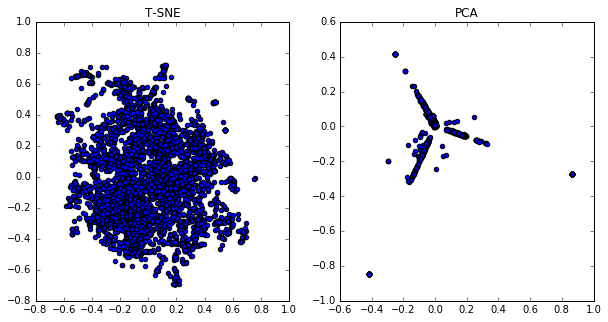

In [38]:
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('T-SNE')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA')

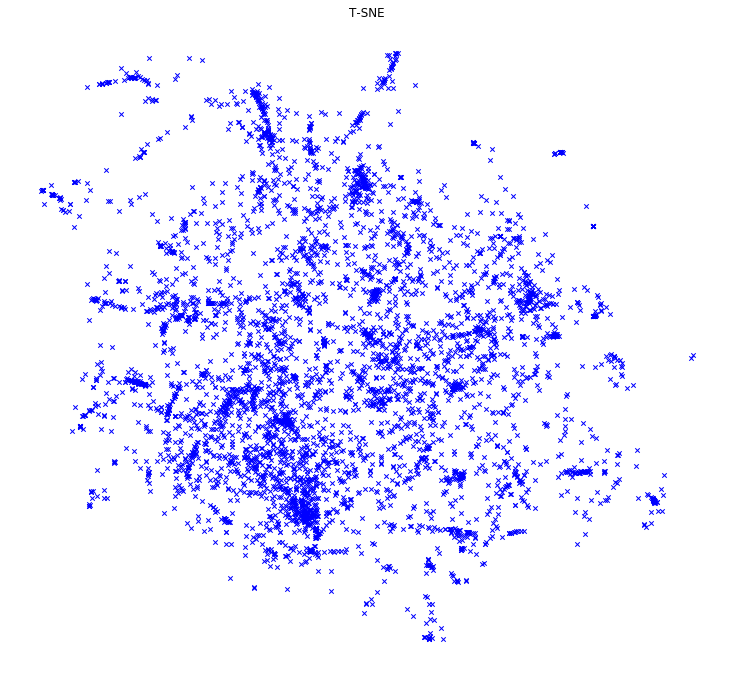

In [39]:
fig = figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,wspace=0.0, hspace=0.0)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],marker="x")
plt.title('T-SNE')

# Future Directions

These are the kinds of questions we would like to pursue in the future:

* Predict the next question a user may ask based on this current search

* The raw data has user-generated tags for all the questions asked. Use supervised learning algorithms against this data set.

* Build a browser plugin for the use case discussed in the introduction

We are always live @ https://github.com/dhruvaray/soml


## References

* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
* LDA Viz - http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
* This dashboard @ https://github.com/dhruvaray/soml
    